In [1]:
import tensorflow as tf
import pandas as pd
import sklearn
import matplotlib
import keras
import numpy as np
import matplotlib.pyplot as plt
import time

# Import training data 
df = pd.read_csv('case3_data3.csv')

dataset = df.values

X = dataset[:,0:7]
Y = dataset[:,7]
Y1 = Y.reshape(-1, 1)


Using TensorFlow backend.


In [2]:
# Note! scaling is not used for Gradient Boosting
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)

Y_scale = min_max_scaler.fit_transform(Y1)

# Split data into traning and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25)
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(749, 7) (250, 7) (749,) (250,)


Time for GBR fitting: 1.238
Mean Squared Error for Gradient Boosting: 0.0004790395278412681


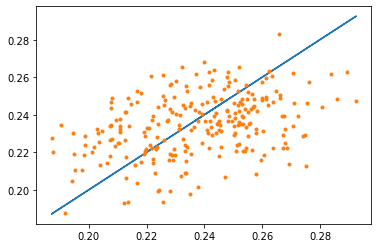

In [3]:
# Fit Gradient Boosting 
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(n_estimators=1000)

stime = time.time()
gb.fit(X_train, Y_train)
print("Time for GBR fitting: %.3f" % (time.time() - stime))
#X_val = X;
#Y_val = Y;
Y_pred_gb = gb.predict(X_val)
mae = np.mean(abs(Y_pred_gb - Y_val))
mse = np.mean((Y_pred_gb - Y_val)**2)
print('Mean Squared Error for Gradient Boosting:', mse)

plt.plot(Y_val,Y_val)
plt.plot(Y_val,Y_pred_gb,'.')

In [4]:
# ------------ Closed-loop testing starts here ! --------------
# import and initialize model 
import Model as model

df = pd.read_csv('case3_Testdata3.csv')
dataset = df.values

X_test = dataset[:,0:7]
Y_test = dataset[:,7]
bias =  dataset[:,8:15]
dist = dataset[:,15:23]
Jopt = dataset[:,23]
uopt = dataset[:,24]

print(dataset.shape)

(999, 25)


In [5]:
J = []
U = []
Ju = []

for i in range(999):
    class parameters():
        T0=dist[i,0]    
        w0=dist[i,1]    
        wh1=dist[i,2]  
        wh2=dist[i,3]  
        Th1=dist[i,4]  
        Th2=dist[i,5]  
        UA1=dist[i,6]  
        UA2=dist[i,7]  
    
    par = parameters()

    # initial operating point
    u = 0.5
    meas = model.hex_output(u,par)
    y = [np.array([meas[0],meas[7],meas[5],meas[6],par.w0,par.wh1,par.wh2])]

    # iterate for 30 steps (until convergence)
    
    for j in range(30):
        u = gb.predict(y)
        meas = model.hex_output(u,par) 
        y = [np.array([meas[0],meas[7],meas[5],meas[6],par.w0,par.wh1,par.wh2] + bias[i,:])]
        
    # save the converged values of cost, input and gradient   
    J.append(meas[7])
    U.append(u)

-0.007074001487495707


Text(0.5, 1.0, 'Input u')

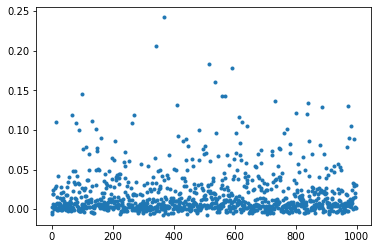

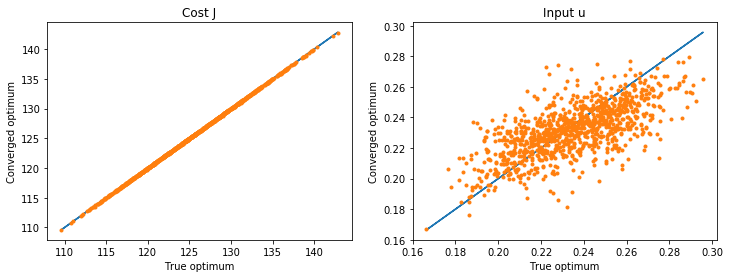

In [6]:
# plot results 
J_cl = np.array(J)
J_cl = J_cl.reshape(999,)

Jopt = np.array(Jopt)
Jopt = Jopt.reshape(999,)

plt.plot(-Jopt-J_cl,'.')
print(min(-Jopt-J_cl))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                                       sharex=False, figsize=(12, 4))

ax1.plot(-Jopt,-Jopt)
ax1.plot(-Jopt,J,'.')
ax1.set_xlabel('True optimum')
ax1.set_ylabel('Converged optimum')
ax1.set_title('Cost J')

ax2.plot(uopt,uopt)
ax2.plot(uopt,U,'.')
ax2.set_xlabel('True optimum')
ax2.set_ylabel('Converged optimum')
ax2.set_title('Input u')